<a href="https://colab.research.google.com/github/yingzibu/ODE/blob/main/experiment/IV/one_compartment/multiple_dosing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In reality, we only have Ac data

## And what if we have tlag? (Solved)

## What if multiple dosing?

In [ ]:
! pip install torchdiffeq --quiet
! pip install latex --quiet

In [2]:
import os
import argparse
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings

matplotlib.rcParams['figure.figsize'] = (3.5, 3)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
# constant
method_ode = 'dopri5'
data_size = 1000
batch_time = 10
batch_size = 512
niters = 2000
test_freq = 3
viz = True
gpu_num = 0
adjoint = True
fig_path = 'png'
device = torch.device('cuda:'+str(gpu_num) if torch.cuda.is_available() else 'cpu')

First order, thus ODE:
\begin{equation*}
     \frac{d A_c}{d t} =  - K A_c, \qquad  \text{IC} : A_c = D \text{ when } t = t_{\text{lag}};
\end{equation*}

solve this ODE and we obtain
\begin{align*}
    \frac{d A_c}{Ac} &= -K d t \\
    d \ln(A_c) &= d (-Kt) \\
    A_c &= {\rm C} {\rm e}^{-Kt}
\end{align*}
in which C is constant. Given the initial condition
Thus the equation is
\begin{equation*}
     A_c = D {\rm e}^{-K(t-t_{\rm lag})}
\end{equation*}
Usually $t_{\rm lag} = 0$, thus
\begin{align*}
    A_c &= D {\rm e}^{-Kt} \\
    Conc. & = \frac{D {\rm e}^{-Kt}}{V_d}
\end{align*}

If multiple dosing, the ODE remains the same, yet the condition changes at $t%\tau ==0$ as $A (\lambda * \tau) += MD$, in which $\lambda$ is the dosing repetition, $\tau$ is the dosing interval, and $MD$ is the maintenance dose (may or may not be the same as the loading dose)

### How to tackle multiple dosing? Like truncate into multiple intervals regarding to $\tau$?

In [38]:
# first order PO related constants
Dose = 2.0 # initial dose for PO, loading dose
MD = 1.5 # Maintenance dose
k = 0.2
MAX_T = 25
t_lag = 0.9
tau = 8 # dosing interval
lam = 4 # dosing lam times
apply_mask = False

MAX_T = max(MAX_T, tau*(lam+1))


In [39]:
true_M = torch.tensor([[-k]]).to(device)
true_y0 = torch.tensor([[Dose]]).to(device) # initial conditions for Aa and A
t = torch.linspace(t_lag, MAX_T+t_lag, data_size).to(device) # consider t_lag

dim = true_y0.shape[-1]
class Lambda(nn.Module):
    def forward(self, t, y, t_lag=t_lag): # need transpose M, since y is a row vector
        if t < t_lag: # consider lag time, return dy/dt = 0, thus Amount will remain the same
            return torch.mm(y, torch.zeros([dim,dim]).to(device))
        return torch.mm(y, true_M.T)

with torch.no_grad():
    for i in range(lam):
        t_here = t[t >= (t_lag + i * tau)]
        t_here = t_here[t_here < (t_lag + (i+1) * tau)]
        if i == 0:
            true_y = odeint(Lambda(),true_y0, t_here, method=method_ode)
        else:
            true_y = torch.cat([true_y, odeint(Lambda(),true_y0,
                                t_here, method=method_ode)], dim=0)
        A_res = true_y[-1]
        true_y0 = torch.tensor([[MD + A_res]]).to(device) # A += MD
    t_here = t[t>=(t_lag + lam*tau)] # After the multiple dose, stop dosing
    true_y = torch.cat([true_y, odeint(Lambda(),true_y0,
                                       t_here, method=method_ode)], dim=0)

    assert true_y.shape[0] == t.shape[0]

In [44]:
class ODEFunc(nn.Module):
    """
    Aim: use NN to approximate ode_func.
    Input dim should be the same as output dim,
    since dy/dt has the same dim of y

    param dim: int, input dimension
    return
        dy/dt, which is ode_func value at y
    """
    def __init__(self, dim=dim, t_lag=t_lag):
        super(ODEFunc, self).__init__()
        self.t_lag = t_lag
        self.net = nn.Sequential(
            nn.Linear(dim, 50),
            nn.Tanh(),
            nn.Linear(50, dim)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
    def forward(self, t, y):
        # if t < self.t_lag: # dy/dt = [0], no change in either compartment
            # return torch.zeros(y.shape)
        return self.net(y)




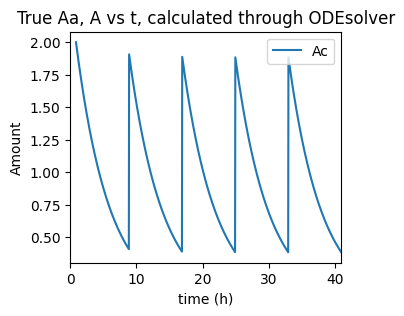

In [41]:
fig = plt.figure()
plt.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,0,0])
t_max = t.max().cpu().numpy().item()
plt.legend(['Ac'])
plt.xlim([0., t_max])
plt.xlabel('time (h)')
plt.ylabel('Amount')
if apply_mask:
    plt.title('True Aa, A vs t, calculated through ODEsolver, Aa is ignored')
else:plt.title('True Aa, A vs t, calculated through ODEsolver')
plt.show()
plt.close()

## Explicit function

(1000, 1, 1)


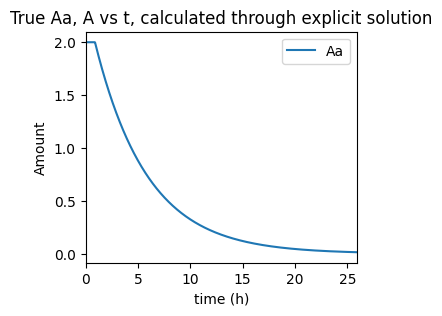

In [ ]:
# def explicit_solution_IV_one_compartment(t, k=k, D=Dose, MD=MD,
#                                          t_lag=t_lag, lam=lam, tau=tau):

#     if t < t_lag:
#         A = np.array([[D]])
#     else:

#         t_here = t - t_lag
#         A = D * np.exp(-k * t_here)
#     return A.reshape(1,1)

# explicit_solution = explicit_solution_IV_one_compartment

# fig = plt.figure()
# true_y_explicit = np.stack(([explicit_solution(t_) for t_ in time_]))
# # print(true_y_explicit.shap?e)
# plt.plot(time_, true_y_explicit[:,0,0])
# t_max = t.max().cpu().numpy().item()


# plt.legend(['Ac'])
# plt.xlim([0., t_max])
# plt.xlabel('time (h)')
# plt.ylabel('Amount')
# plt.title('True Ac vs t, calculated through explicit solution')
# plt.show()
# plt.close()

In [46]:
def get_batch(): # use the estimated ka to generate new batch data

    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time,
                                                    dtype=np.int64),
                         batch_size, replace=False))
    # print(s)
    batch_y0 = true_y[s]
    batch_t = t[:batch_time]
    batch_y = torch.stack([true_y[s+i] for i in range(batch_time)], dim=0)
    try:
        if pred_ka != None and apply_mask == True:
            batch_y0[:, :, 0] = pred_y_pred_ka[s][:, :, 0]
            batch_y[:,:,:,0] = torch.stack([
                pred_y_pred_ka[s+i] for i in range(batch_time)], dim=0)[:,:,:,0]
    except:
        pass


    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

def makedirs(dirname):
    if not os.path.exists(dirname): os.makedirs(dirname)

Epoch 0000 | Total Loss 20.602
Epoch 0003 | Total Loss 16.242
Epoch 0006 | Total Loss 11.954
Epoch 0009 | Total Loss 7.797
Epoch 0012 | Total Loss 3.956
Epoch 0015 | Total Loss 0.974
Epoch 0018 | Total Loss 0.934
Epoch 0021 | Total Loss 1.423
Epoch 0024 | Total Loss 1.613
Epoch 0027 | Total Loss 1.648
Epoch 0030 | Total Loss 1.637
Epoch 0033 | Total Loss 1.614
Epoch 0036 | Total Loss 1.579
Epoch 0039 | Total Loss 1.535
Epoch 0042 | Total Loss 1.483
Epoch 0045 | Total Loss 1.425
Epoch 0048 | Total Loss 1.364
Epoch 0051 | Total Loss 1.305
Epoch 0054 | Total Loss 1.250
Epoch 0057 | Total Loss 1.200
Epoch 0060 | Total Loss 1.156
Epoch 0063 | Total Loss 1.118
Epoch 0066 | Total Loss 1.084
Epoch 0069 | Total Loss 1.055
Epoch 0072 | Total Loss 1.027
Epoch 0075 | Total Loss 0.997
Epoch 0078 | Total Loss 0.962
Epoch 0081 | Total Loss 0.923
Epoch 0084 | Total Loss 0.885
Epoch 0087 | Total Loss 0.852
Epoch 0090 | Total Loss 0.824
Epoch 0093 | Total Loss 0.801
Epoch 0096 | Total Loss 0.778
Epoch 0

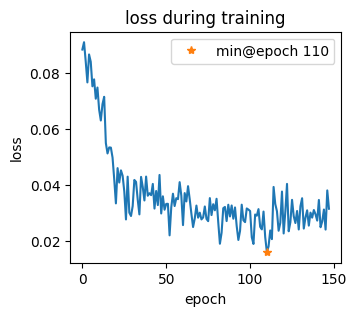

Epoch 0150 | Total Loss 0.712
Epoch 0153 | Total Loss 0.713
Epoch 0156 | Total Loss 0.714
Epoch 0159 | Total Loss 0.712
early stop


In [47]:
def visualize_dim_2(true_y, pred_y, odefunc, itr, fig_path=None):
    if fig_path==None: fig_path = 'png'; makedirs(fig_path)
    fig, (ax_traj, ax_phase, ax_vecfield) = plt.subplots(1, 3, figsize=(12,4))

    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('Aa, A')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,0,0],
                 t.cpu().numpy(), true_y.cpu().numpy()[:,0,1], 'g-')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0], '--',
                 t.cpu().numpy(), pred_y.cpu().numpy()[:,0,1], 'b--')
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    ax_traj.set_ylim(-0.1, Dose * 1.1) # Since Aa and A cannot exceed [0, Dose]
    ax_traj.legend(['True Aa', 'True A', 'Pred Aa', 'Pred A'])

    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('Aa')
    ax_phase.set_ylabel('A')
    ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
    ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
    ax_phase.set_xlim(-0.1, Dose*1.1) # since Aa cannot exceed [0, Dose]
    ax_phase.set_ylim(-0.1, Dose*1.1) # since A  cannot exceed [0, Dose]
    ax_phase.legend(['True', 'Pred'])

    ax_vecfield.cla()
    ax_vecfield.set_title('Learned Vector Field')
    ax_vecfield.set_xlabel('Aa')
    ax_vecfield.set_ylabel('A')

    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlim(-2, 2)
    ax_vecfield.set_ylim(-2, 2)


    # plt.savefig('png/{:03d}'.format(itr))
    fig.suptitle('Iteration {:03d}'.format(itr))
    fig.tight_layout()
    fig.savefig('png/{:03d}'.format(itr))
    # plt.draw()
    # plt.pause(0.001)
    plt.close(fig)



def visualize_dim_1(true_y, pred_y, mean_df, itr, fig_path=None, true_k=k):
    if fig_path==None: fig_path = 'png'; makedirs(fig_path)
    fig, (ax_traj, ax_k) = plt.subplots(1, 2, figsize=(8,4))

    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('Ac')
    time_ = t.cpu().numpy()

    ax_traj.plot(time_, true_y.cpu().numpy()[:,0,0])
    ax_traj.plot(time_, pred_y.cpu().numpy()[:,0,0], 'g--')

    t_max = t.max().cpu().numpy().item()

    ax_traj.set_xlim([0., t_max])
    ax_traj.set_ylim([-0.1, Dose*1.1])
    ax_traj.legend(['True A', 'Pred A'])



    ax_k.cla()
    ax_k.set_title('Model prediction of -k')
    ax_k.set_xlabel('iter')
    ax_k.set_ylabel('value')
    ax_k.plot(np.arange(ii+1), mean_df.iloc[0].tolist(), marker='.',
              label=f'pred -k = {mean_df.iloc[0].tolist()[-1]:.3f}')
    ax_k.axhline(y=-k, color='r', linestyle='-', label=f'true value={-k:.3f}')
    ax_k.legend(loc='upper right')
    # plt.title('True Aa, A vs t, calculated through explicit solution')

    # plt.savefig('png/{:03d}'.format(itr))
    fig.suptitle('Iteration {:03d}'.format(itr))
    fig.tight_layout()
    fig.savefig('png/{:03d}'.format(itr))

    plt.close(fig)



if dim == 1: visualize = visualize_dim_1
if dim == 2: visualize = visualize_dim_2
ii = 0
func = ODEFunc().to(device)
optimizer = optim.AdamW(func.parameters(), lr=1e-3, weight_decay=1e-4)
# end = time.time()
min_loss = np.inf
min_epoch = 0
loss_all = []
patience = 50
fig_freq = 50
model_path_ = 'test.pt'
mean_df = pd.DataFrame()

if apply_mask: pred_ka = 0 # initialize pred_ka

for epoch in range(niters):
    func.train()
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y-batch_y))
    loss_all.append(loss.item())
    loss.backward()
    optimizer.step()

    if loss.item() < min_loss: # loss drop, save model
        min_loss = loss.item(); min_epoch = epoch
        torch.save(func.state_dict(), model_path_)

    if epoch - min_epoch > patience:
        print('early stop'); break

    if epoch % test_freq == 0:
        func.eval()
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y-true_y)) # all loss, include Aa
            print('Epoch {:04d} | Total Loss {:.3f}'.format(epoch, loss.item()))


            y_nn = func(_, true_y)
            y_nn = y_nn.reshape(y_nn.shape[0], dim).cpu().detach()
            y_temp = true_y.reshape(true_y.shape[0], dim).cpu().detach()
            M_T = torch.linalg.inv(y_temp.T @ y_temp)
            M_T = M_T @ y_temp.T @ y_nn
            M_T = M_T.reshape(dim*dim).numpy()
            # print(M_T, type(M_T))
            if apply_mask: # update pred_ka
                pred_ka = M_T[1]
                if pred_ka < 0: pred_ka = 0
                print('update pred_ka:', pred_ka)

            mean_df[f'iter {ii}'] = pd.DataFrame(M_T)
            if viz: visualize(true_y, pred_y, mean_df, ii) # ii is the png figure pass num

            # fig, axs = plt.subplots(dim, dim, figsize=(10,5))
            # true_values = true_M.T.cpu().detach().numpy().reshape(dim*dim)

            # for i in range(dim):
            #     for j in range(dim):
            #         axs[i][j].cla(); idx = j*dim + i
            #         true_value = true_values[idx]
            #         axs[i][j].plot(
            #             np.arange(ii+1), mean_df.iloc[idx].tolist(), marker='.',
            #             label=f'pred M{i,j} = {mean_df.iloc[idx].tolist()[-1]:.3f}')
            #         axs[i][j].axhline(y=true_value, color='r', linestyle='-',
            #                           label=f'true value = {true_value:.3f}')
            #         axs[i][j].legend(loc='upper right')
            # fig.suptitle('Model estimation of M during train, iter={:03d}'.format(ii))
            # fig.tight_layout()
            # makedirs('M_estimate')
            # fig.savefig('M_estimate/{:03d}'.format(ii))


            ii += 1

            # if ii % fig_freq == 0: plt.show(fig)
            # plt.close(fig)


            # Visualize loss during training
            if ii % fig_freq == 0:
                plt.plot(loss_all)
                plt.plot(min_epoch, min_loss, '*',
                         label=f'min@epoch {min_epoch}')
                plt.xlabel('epoch'); plt.ylabel('loss');
                plt.title('loss during training')
                plt.legend(); plt.show(); plt.close()


load model from path:  test.pt


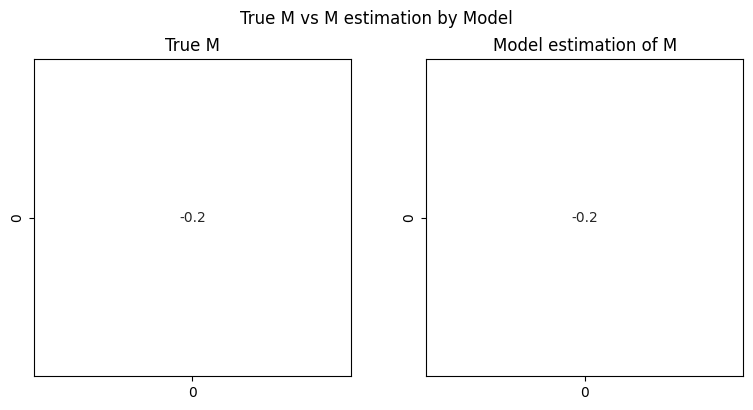

In [49]:
def load_model(model, path, device='cpu'):
    print('load model from path: ', path)
    model.load_state_dict(torch.load(path, map_location=device))

load_model(func, model_path_)

y_nn = func(_, true_y)
y_temp = true_y.reshape(true_y.shape[0], dim).cpu().detach()
M_T = torch.linalg.inv(y_temp.T @ y_temp)
M_T = M_T @ y_temp.T @ (y_nn.reshape(y_nn.shape[0], dim).cpu().detach())

true_M_ = true_M.cpu().detach().numpy()
pred_M_ = M_T.T.numpy()
fig, (ax_true, ax_pred) = plt.subplots(1, 2, figsize=(8,4))

ax_true.cla()

sns.heatmap(true_M_, annot=True, square=True,
            cmap='gray_r', vmin=0, vmax=0,  # set all to white
            linewidths=0.5, linecolor='k',  # draw black grid lines
            cbar=False, ax=ax_true)         # disable colorbar
sns.despine(left=False, right=False, top=False, bottom=False)
ax_true.set_title('True M')

ax_pred.cla()
sns.heatmap(pred_M_, annot=True, square=True,
            cmap='gray_r', vmin=0, vmax=0,  # set all to white
            linewidths=0.5, linecolor='k',  # draw black grid lines
            cbar=False, ax=ax_pred)         # disable colorbar
sns.despine(left=False, right=False, top=False, bottom=False)
ax_pred.set_title('Model estimation of M')

fig.suptitle('True M vs M estimation by Model')
fig.tight_layout(); plt.show(fig); plt.close(fig)

<ipython-input-50-4f1c972f006e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


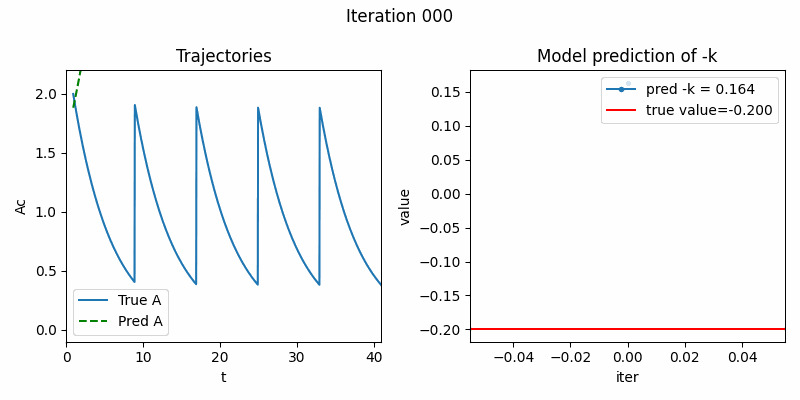

In [50]:
import imageio
images = []
# for filename in filenames:
for i in range(ii):
    filename = '{:03d}.png'.format(i)
    filename = f'{fig_path}/{filename}'
    images.append(imageio.imread(filename))
imageio.mimsave('png/gif.gif', images, fps=3)
from IPython.display import Image
Image('png/gif.gif')